In [1]:
!pip install -Uq diffusers transformers fastcore
!mkdir -p /root/.cache/huggingface
!cp /notebooks/huggingface-token /root/.cache/huggingface/token
import math
from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload
from IPython.display import display
from transformers import CLIPTextModel, CLIPTokenizer
import  torch
from diffusers import LMSDiscreteScheduler
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from PIL import Image
logging.disable(logging.WARNING)
torch.manual_seed(1)

from tqdm.auto import tqdm
from diffusers import AutoencoderKL, UNet2DConditionModel
import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()
clear_gpu()
from torchvision import transforms as tfms
from scipy.ndimage import uniform_filter

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype=torch.float16)
text_encoder=CLIPTextModel.from_pretrained(
    'openai/clip-vit-large-patch14',
    torch_dtype=torch.float16).to('cuda')

In [4]:
1

1

In [3]:
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-ema",
    torch_dtype=torch.float16
).to('cuda')

unet=UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4',
    subfolder='unet',
    torch_dtype=torch.float16
).to('cuda')

In [5]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        t=tfms.ToTensor()(input_im).unsqueeze(0).to('cuda').half()*2-1
        if (t.shape[1] == 4):
            t=t[:,:-1]
        latent = vae.encode(t) # Note scaling
    return 0.18215 * latent.latent_dist.sample()
def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [6]:
def show_latents(latents):
    if len(latents) == 64:
        plt.imshow(latents.cpu(),cmap='gray')
        plt.show()
        
    else:
        fig,axes=plt.subplots(1,4,figsize=(32,8))
        for i in range(4):
            with torch.no_grad():
                axes[i].imshow(latents[0][i].cpu(),cmap='gray')


### get im and latent

In [7]:
horse1 = Image.open('./imgs/horse1.png')
horse1=horse1.resize((512,512))
horse2 = Image.open('./imgs/horse2.png')
horse2=horse2.resize((512,512))
im = Image.open(FastDownload().download('https://wallpaperaccess.com/full/275808.jpg'))
im = im.resize((512,512))
im2 = Image.open(FastDownload().download('http://4.bp.blogspot.com/-W-Q7_l1OoxY/UWAJSrtvn_I/AAAAAAAASVM/eMqye-hpAu4/s1600/world-s-cutest-kitten.jpg'))
im2 = im2.resize((512,512))

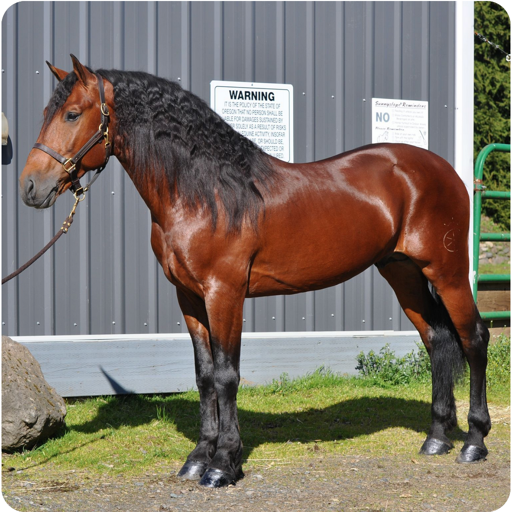

In [10]:
horse1

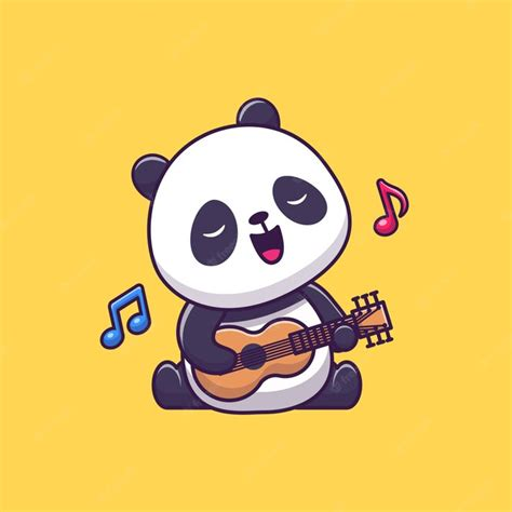

In [7]:
panda = Image.open('./imgs/panda guitar.jpg').resize((512,512))
panda

# Making a pipeline

In [11]:
beta_start,beta_end=0.00085,0.012
scheduler=LMSDiscreteScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000)

In [12]:
def callback(i, latent, renoised_latent):
    if i % 10 == 0:
        display(latents_to_pil(latent)[0])
        display(latents_to_pil(renoised_latent)[0])

In [13]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

def mk_samples(prompt, g=7.5, seed=100, steps=70, init_im=None, neg_prompt=None, cb=None, cos=False):
    text = text_enc([prompt])
    
    if neg_prompt is None:
        uncond = text_enc([""])
    else:
        uncond = text_enc([neg_prompt])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half() 
    scheduler.set_timesteps(steps)
    
    if init_im is None:
        latents = noise* scheduler.init_noise_sigma
        start_step=0
    else:
        start_step=steps//5
        init_latent=pil_to_latent(init_im)
        print(init_latent.shape, noise.shape)
        latents=scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[start_step]]))
                                    
    scaled_g=torch.cos(torch.range(0., math.pi, (math.pi)/steps))
    scaled_g=((scaled_g+1)*(g/2))
    # print(scaled_g)
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

            if cos:
                pred = u + scaled_g[i]*(t-u)
            else:
                pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample
            if cb is not None:
                cb(i, latents)

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample.squeeze()


In [14]:
def stats(t):
    print(f"min {t.min()} max {t.max()} med {t.median()} mean {t.mean()}")

In [16]:
def generate_mask(reference, query, im, steps=70):
    query_emb = text_enc([query])
    ref_emb = text_enc([reference])
    
    emb = torch.cat([query_emb, ref_emb])

    noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half() 
    scheduler.set_timesteps(steps)
    
    start_step=steps - (steps//2)
    init_latent=pil_to_latent(im)
    start_ts=torch.tensor([scheduler.timesteps[start_step]]).to('cuda')
    latents=scheduler.add_noise(init_latent, noise, start_ts)
    #latents = init_latent + noise/2
                                    
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), start_ts)
    with torch.no_grad(): q,r = unet(inp, start_ts, encoder_hidden_states=emb).sample.chunk(2)
    ###
    #from https://github.com/Xiang-cd/DiffEdit-stable-diffusion/blob/main/diffedit.ipynb
    diffabs=(q-r).abs_()
    print('diffabs')
    stats(diffabs)
    show_latents(diffabs)
    subed = diffabs.mean(dim=[0,1])
    max_v = subed.mean() * 3
    print(f'max_v {max_v}')
    mask = subed.clamp(0, max_v) / max_v
    print('mask unbinarized')
    stats(mask)
    show_latents(mask)
    mask=(mask>.5).half()
    print('mask binarized')
    show_latents(mask)
    return mask
    ###
    d=(q.abs().squeeze().sum(dim=0)-r.abs().squeeze().sum(dim=0)).abs()
    show_latents(d)
    stats(d)

    smoothed = torch.tensor(uniform_filter(d.cpu().float(), size=5))
    show_latents(smoothed)
    stats(smoothed)
    
    smoothed = (smoothed > smoothed.mean()).float()
    show_latents(smoothed)
    stats(smoothed)
    mask=smoothed
    return mask.half()


In [17]:
reference='a horse in front of a metal wall'
query='a zebra in front of a metal wall'
im=horse1
steps=50
query_emb = text_enc([query])
ref_emb = text_enc([reference])

emb = torch.cat([query_emb, ref_emb])

noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half() 
scheduler.set_timesteps(steps)

start_step=steps - (steps//2)
init_latent=pil_to_latent(im)
start_ts=torch.tensor([scheduler.timesteps[start_step]]).to('cuda')
latents=scheduler.add_noise(init_latent, noise, start_ts)
#latents = init_latent + noise/2

inp = scheduler.scale_model_input(torch.cat([latents] * 2), start_ts)
with torch.no_grad(): q,r = unet(inp, start_ts, encoder_hidden_states=emb).sample.chunk(2)

/tmp/ipykernel_144/4244325261.py:10: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()


diffabs
min 0.0 max 0.4609375 med 0.00787353515625 mean 0.0172882080078125


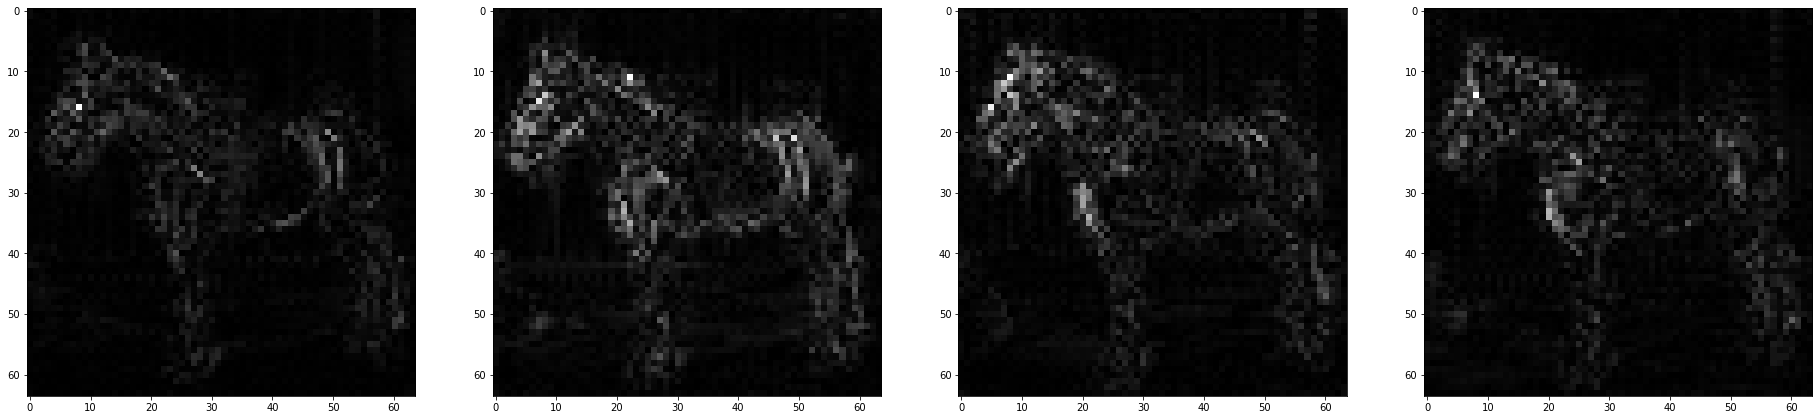

In [18]:
###
#from https://github.com/Xiang-cd/DiffEdit-stable-diffusion/blob/main/diffedit.ipynb
diffabs=(q-r).abs_()
print('diffabs')
stats(diffabs)
show_latents(diffabs)

max_v 0.0518798828125
mask unbinarized
min 0.0117645263671875 max 1.0 med 0.1788330078125 mean 0.305908203125


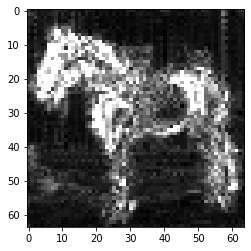

In [19]:
subed = diffabs.mean(dim=[0,1])
max_v = subed.mean() * 3
print(f'max_v {max_v}')
mask = subed.clamp(0, max_v) / max_v
print('mask unbinarized')
stats(mask)
show_latents(mask)

min 0.06211944669485092 max 0.8355090022087097 med 0.24852752685546875 mean 0.30587875843048096


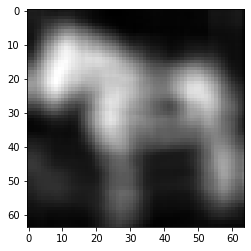

In [20]:
blurred=torch.tensor(uniform_filter(mask.float().cpu(),size=10)).to('cuda')
stats(blurred)
show_latents(blurred)

mask binarized


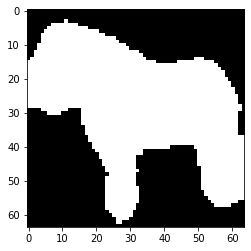

In [21]:
maskb=(blurred>.25).half()
print('mask binarized')
show_latents(maskb)

In [27]:
def mk_sample_w_mask(prompt, mask, init_im, g=7.5, seed=100, steps=70, neg_prompt=None, cb=None, cos=False, start_ratio=.7):
    text = text_enc([prompt])
    mask=mask.to('cuda')

    if neg_prompt is None:
        uncond = text_enc([""])
    else:
        uncond = text_enc([neg_prompt])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
    scheduler.set_timesteps(steps)

    if init_im is None:
        raise 'oops'
    else:
        start_step=math.floor(steps * start_ratio)
        init_latent=pil_to_latent(init_im)
        latents=scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[start_step]]))
    
    scaled_g=torch.cos(torch.range(0., math.pi, (math.pi)/steps))
    scaled_g=((scaled_g+1)*(g/2))
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step:
            inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
            with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

            if cos:
                pred = u + scaled_g[i]*(t-u)
            else:
                pred = u + g*(t-u)
            latents = scheduler.step(pred, ts, latents).prev_sample
            renoised_init = scheduler.add_noise(init_latent, noise, ts.unsqueeze(0))
            masked = latents * mask + renoised_init*(1-mask)
            if cb is not None:
                cb(i, latents, renoised_init)
            latents=masked

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample.squeeze()


In [32]:
latentlist=[]
def savelatent(i, latents, _):
    latentlist.append(latents)

/tmp/ipykernel_144/4252956112.py:12: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  noise = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
/tmp/ipykernel_144/4252956112.py:22: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  scaled_g=torch.cos(torch.range(0., math.pi, (math.pi)/steps))


  0%|          | 0/100 [00:00<?, ?it/s]

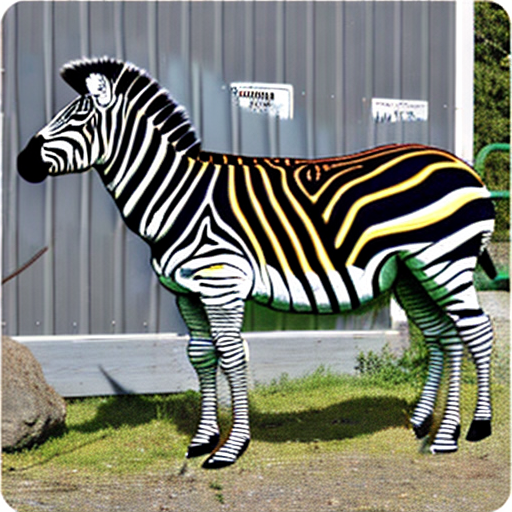

In [59]:
s=mk_sample_w_mask(query, maskb, horse1, steps=100,g=15, start_ratio=.2, cb=savelatent)
mk_img(s)

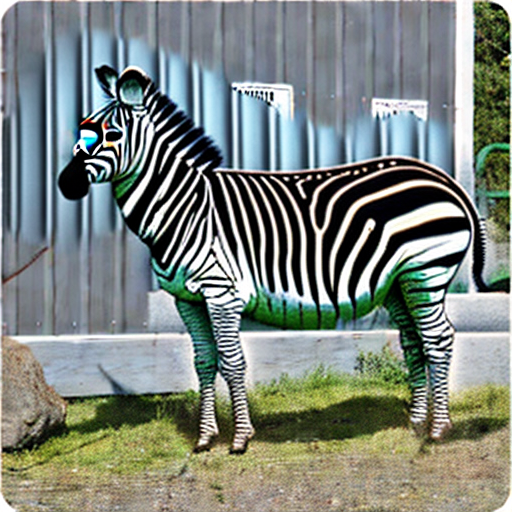

In [36]:
latents_to_pil(latentlist[-1])[0]

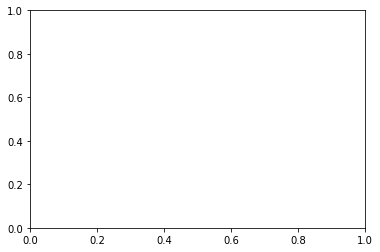

In [60]:
fig,ax = plt.subplots()

In [61]:
nframes=5
length = len(latentlist)
for fnum in range(0,5):
    print(length - (5-fnum) * length//5)

0
24
47
70
93


In [62]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [66]:
nframes=10
length = len(latentlist)
def one_frame(fnum):
    idx=length - (nframes-fnum) * length//nframes
    ax.clear()
    ax.imshow(latents_to_pil(latentlist[idx])[0])

In [67]:
ani=FuncAnimation(fig, one_frame, frames=nframes, interval=500,repeat=True)

In [68]:
plt.close()
HTML(ani.to_jshtml())

In [25]:
def diffedit(sourcetext, querytext, im, cos, g, mask_threshold, start_ratio, steps=50):
    mask=generate_mask(sourcetext, querytext, im, mask_threshold=mask_threshold)
    #blurred=torch.tensor(uniform_filter(mask.cpu().float(), size=10)).to('cuda').half()
    sample=mk_sample_w_mask(querytext, mask, im, cos=cos, g=g, start_ratio=start_ratio,steps=steps)
    return mk_img(sample)

In [ ]:
coss=[True]
gs=[7.5,12]
mask_thresholds=[0.03]
start_ratios=[.05,.1,.25]

for cos in coss:
    for g in gs:
        for mask_threshold in mask_thresholds:
            for start_ratio in start_ratios:
                print(f'cos={cos}, g={g}, mask={mask_threshold}, start_ratio={start_ratio}')
                display(diffedit('a photograph of a horse in front of a wall','a photograph of a zebra in front of a wall', horse1,
                                cos, g, mask_threshold, start_ratio))

In [ ]:
#sourcetext='a photograph of a horse in front of a wall'
#querytext='a photograph of a cow in front of a wall'
sourcetext='a guitar'
querytext='a violin'
display(diffedit(sourcetext, querytext, panda, True, 7.5, .01, .1, steps=50))


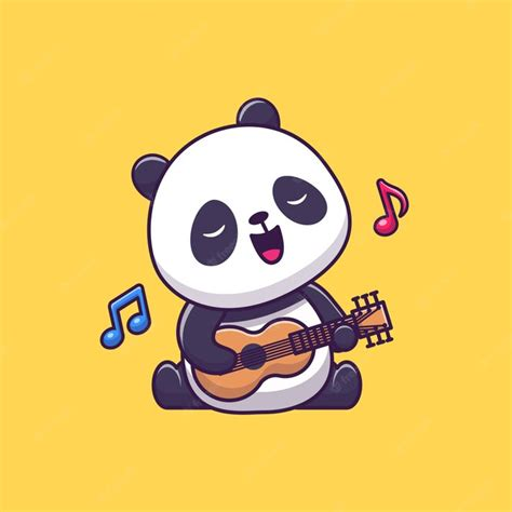

In [72]:
display(panda)

In [ ]:
display(diffedit('a photograph of a horse in front of a wall','a photograph of a  in front of a wall', horse1))

In [ ]:
display(horse1)

In [ ]:
import time
time.localtime()

# 

# 